<div align="center"> <h1> 
Bamboost<br/>
🐼🐼🐼🐼
</h1> </div>

Bamboost is a Python library built for datamanagement using the HDF5 file format.
bamboost stands for a lightweight shelf which will boost your efficiency and which
will totally break if you load it heavily. Just kidding, bamboo can fully carry pandas. 

### Data architecture
<img src="./assets/data_architecture.excalidraw.png" >

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from bamboost import Manager

from lattice_model import LatticeModel

## Parametric study
Let's run many simulations on the lattice model from before.

Remember that we have 3 parameters:
- `N` controls the amount of nodes
- `E` is the young's modulus which we will keep constant and equal to $1$ for brevity
- `randomness` is a parameter we use to randomly move the points away from their position in a regular grid. The larger it is, the further the points are moved from the initial position.

The young's modulus is very uninteresting in this case, so we'll limit ourselfs on the number of nodes and the perturbation of nodal positions.



### Model execution
We imitate some program which computes the model with a simple function.
It will take a bamboost `simulation` object as input and run all the computations.

Let's first build this function. It is the same as in the previous tutorial.
Contrary to before, we will also store the loadsteps as an input parameter of the simulation.
To do so, we just add the numpy array with the steps in our parameter dictionary.

In [8]:
def run_simulation(sim):
    """Execute the model computation.
    
    Args:
        sim: the simulation object
    """

    # RETRIEVE THE PARAMETERS
    parameters = sim.parameters

    # setup the lattice model
    model = LatticeModel(parameters['E'], parameters['N'], parameters['randomness'])

    with sim:
        # WRITE THE MESH:
        sim.add_mesh(model.coordinates, model.connectivity)
        
        # WRITE METADATA:
        sim.add_metadata()
        
        # MAKE A NOTE FOR LATER YOU:
        sim.change_note('we are on the mountain')

        # model: loop through the loadsteps
        loadsteps = parameters['loadsteps']

        for disp, change in zip(loadsteps, np.diff(loadsteps, prepend=0)):
            model.move_top(change)
            model.solve()
            
            # WRITE THE NODAL DISPLACEMENTS FOR THIS STEP (use the displacement value as "time"):
            sim.add_field('nodal_displacement', model.displacements, time=disp)
            
            # WRITE THE NODAL FORCES FOR THIS STEP:
            sim.add_field('nodal_force', model.forces, time=disp)

            # WRITE THE TOP DISPLACEMENT, AND THE BOTTOM REACTION FORCE:
            sim.add_global_field('top_disp', disp)
            sim.add_global_field('bottom_force_x', model.get_force_bottom()[0])
            sim.add_global_field('bottom_force_y', model.get_force_bottom()[1])
            
            # bamboost: end the step, will increase an internal step counter
            sim.finish_step()
        
    return 'Success yey'


### Creation of simulations
We want to run simulations for the following parameters:
- `N`: 10, 20, 30
- `randomness`: 0.1, 0.2, 0.3

First, we create a bunch of simulations.

In [4]:
# CREATE A NEW DATABASE
db = Manager('database')
db.df

,id,notes,status,E,N,processors,randomness,time_stamp
0,b8c7e04b,,Initiated,1,20,1,0.1,2023-09-03 20:14:14
1,0b9d1a4c,,Initiated,1,30,1,0.3,2023-09-03 20:14:14
2,9d4d5ea6,,Initiated,1,30,1,0.2,2023-09-03 20:14:14
3,cb0ac2c6,,Initiated,1,30,1,0.1,2023-09-03 20:14:14
4,b55528a9,,Initiated,1,10,1,0.1,2023-09-03 20:14:14
5,7809d6f5,,Initiated,1,10,1,0.3,2023-09-03 20:14:14
6,f6b381ae,,Initiated,1,10,1,0.2,2023-09-03 20:14:14
7,52e522a9,,Initiated,1,20,1,0.3,2023-09-03 20:14:14
8,22268ef7,,Initiated,1,20,1,0.2,2023-09-03 20:14:14


In [ ]:
from itertools import product

# DEFINE THE POSSIBLE PARAMETERS
vec_N = [10, 20, 30]
vec_random = [.1, .2, .3]

# We can use product from itertools to get all combinations from the two arrays
for N, randomness in product(vec_N, vec_random):
    
    # CREATE PARAMETER DICTIONARY
    params = {
        'E': 1,
        'N': N,
        'randomness': randomness,
        'loadsteps': np.linspace(0, 2, 20),
    }

    # CREATE SIMULATION IN DATABASE
    db.create_simulation(parameters=params)

In [5]:
# see that we now have 9 simulations in our database
db.df

,id,notes,status,E,N,processors,randomness,time_stamp
0,b8c7e04b,,Initiated,1,20,1,0.1,2023-09-03 20:14:14
1,0b9d1a4c,,Initiated,1,30,1,0.3,2023-09-03 20:14:14
2,9d4d5ea6,,Initiated,1,30,1,0.2,2023-09-03 20:14:14
3,cb0ac2c6,,Initiated,1,30,1,0.1,2023-09-03 20:14:14
4,b55528a9,,Initiated,1,10,1,0.1,2023-09-03 20:14:14
5,7809d6f5,,Initiated,1,10,1,0.3,2023-09-03 20:14:14
6,f6b381ae,,Initiated,1,10,1,0.2,2023-09-03 20:14:14
7,52e522a9,,Initiated,1,20,1,0.3,2023-09-03 20:14:14
8,22268ef7,,Initiated,1,20,1,0.2,2023-09-03 20:14:14


### Execution of simulations
Next, we can execute all simulations.

In [9]:
# LOOP THROUGH ALL SIMULATIONS:
for sim in db.sims(db.df.status=='Initiated', return_writer=True):
    
    print(f'Starting simulation {sim.uid}', flush=True)
    
    # CALL RUN FUNCTION:
    run_simulation(sim)

In [12]:
# see that now all are finished (it has the note)
db.df

,id,notes,status,E,N,processors,randomness,time_stamp
0,b8c7e04b,we are on the mountain,Finished,1,20,1,0.1,2023-09-03 20:28:30
1,0b9d1a4c,we are on the mountain,Finished,1,30,1,0.3,2023-09-03 20:28:34
2,9d4d5ea6,we are on the mountain,Finished,1,30,1,0.2,2023-09-03 20:28:39
3,cb0ac2c6,we are on the mountain,Finished,1,30,1,0.1,2023-09-03 20:28:44
4,b55528a9,we are on the mountain,Finished,1,10,1,0.1,2023-09-03 20:28:49
5,7809d6f5,we are on the mountain,Finished,1,10,1,0.3,2023-09-03 20:28:50
6,f6b381ae,we are on the mountain,Finished,1,10,1,0.2,2023-09-03 20:28:51
7,52e522a9,we are on the mountain,Finished,1,20,1,0.3,2023-09-03 20:28:53
8,22268ef7,we are on the mountain,Finished,1,20,1,0.2,2023-09-03 20:28:55


### Data mining
Now that we have all our runs completed, we can look at results.

<Axes: xlabel='N', ylabel='randomness'>

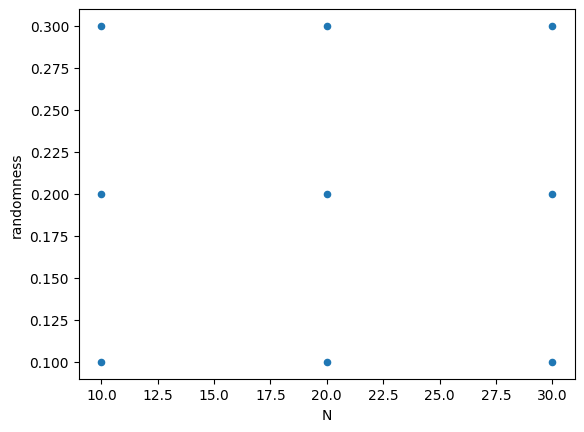

In [23]:
# PLOT THE PARAMETRIC SPACE:
db = Manager('database')
db.df.plot('N', 'randomness', kind='scatter')

{'E': 1, 'N': 10, 'randomness': 0.1, 'loadsteps': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])}


<Axes: >

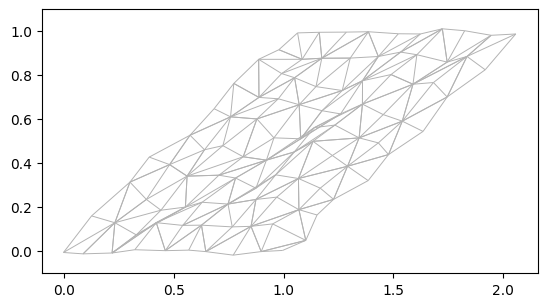

In [79]:
from lattice_model import plot_lattice

# PLOT THE DEFORMED LATTICE FOR A SPECIFIC SIM:
N = 10
randomness = 0.1
sim = db.sims((db.df.N==N) & (db.df.randomness==randomness))[0]
print(sim.parameters)

plot_lattice(*sim.mesh, sim.data['nodal_displacement'][10])

[Text(0.5, 0, 'N'), Text(0, 0.5, 'Fx')]

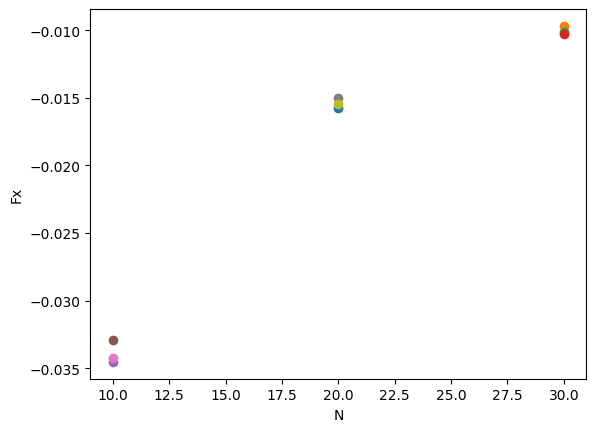

In [80]:
# PLOT THE FINAL HORIZONTAL FORCE VS N:

# colors = [plt.get_cmap('Blues')(i) for i in np.linspace(0, 1, 20)]
for sim in db:
    plt.scatter(
        sim.parameters['N'],
        sim.globals['bottom_force_x'].iloc[-1],
    )

plt.gca().set(xlabel='N', ylabel='Fx')

In [ ]:
# PLOT THE AVERAGE ABSOLUTE NODAL FORCE FOR ALL RUNS OF N=20:
